In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from mpl_toolkits import mplot3d

In [2]:
wdir = os.getcwd()

hits_cols = "hit_id,x,y,z,volume_id,layer_id,module_id,event_name"
particle_cols = "particle_id,vx,vy,vz,px,py,pz,q,nhits,event_name"
truth_cols = "hit_id,particle_id,tx,ty,tz,tpx,tpy,tpz,weight,event_name"
cells_cols = "hit_id,ch0,ch1,value,event_name"

hits_df = pd.DataFrame(columns = hits_cols.split(","))
particle_df = pd.DataFrame(columns=particle_cols.split(","))
truth_df =  pd.DataFrame(columns = truth_cols.split(","))
cells_df = pd.DataFrame(columns= cells_cols.split(','))

In [3]:
events2probe = ['event000001000','event000001001','event000001002','event000001003','event000001004']
fulldir = os.getcwd()+"/data/train_sample"
ctr = 1

for evnt in events2probe:
    fname = fulldir+"/"+evnt
    tmp = pd.read_csv(fname+'-hits.csv')
    tmp['event_name'] = evnt
    hits_df = pd.concat([hits_df,tmp],axis = 0)
    tmp = pd.read_csv(fname+'-truth.csv')
    tmp['event_name'] = evnt
    truth_df = pd.concat([truth_df,tmp],axis = 0)


In [4]:
df  = pd.merge(hits_df,truth_df,how = 'left', on = ['hit_id','event_name'])
df = df[df['particle_id']!= 0] # drop particle 0 
grouped = df.groupby(['event_name','particle_id'])

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


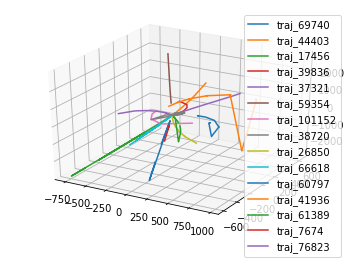

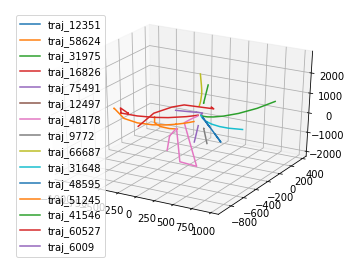

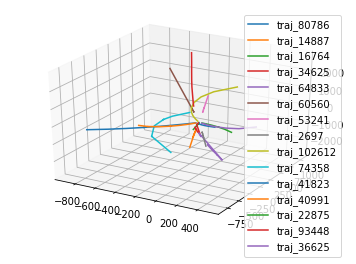

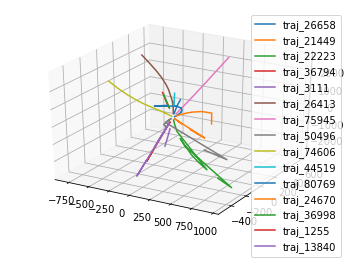

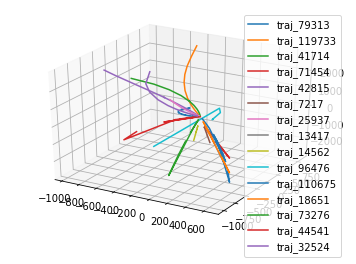

In [5]:
#  now plot the trajectory of several randomly chosen particles for each event
for event2plot in events2probe:
    # get all particles for that event except particle 0 since it exhibits strange behaviour !
    particles_ = df[(df['event_name'] == event2plot)]['particle_id'].values
    fig = plt.figure()
    ax = plt.axes(projection = '3d')
    legend = []
    for i in range(0,15):
        # select a particular group
        pid = np.random.randint(0,len(particles_))
        grp = grouped.get_group((event2plot,particles_[pid]))
        #now plot the group
        grp.sort_values('hit_id', inplace=True )
        ax.plot(grp.tx,grp.ty,grp.tz)
        legend.append('traj_'+str(pid))
    ax.legend(legend)
    # fig.savefig(event2plot+'_random_trajectories.png')

In [6]:
#  lets see the distribution of some metric for the curvature ... 
# 
#  !!! Numerical calculatoin of the trajectory curvature
#  the curvature at a point t for a reparametrized 3D curve
#  is propotional to |d^2r/dt^2|. Since we do not have time-stamps 
#  kappa ~ d^2r 
#  
def calc_curvature(data_fr):
    x = data_fr.tx
    y = data_fr.ty
    z = data_fr.tz
    ddx  = np.diff(np.diff(x))
    ddy  = np.diff(np.diff(y))
    ddz  = np.diff(np.diff(z))
#     take the mean curvature (not the sum) to avoid bias 
#     since some particles generate more hits and others less
    return np.sqrt(ddx**2 + ddy**2 + ddz**2).mean() 
    
#calculate the curvatures


In [8]:
curvatures = grouped.apply(calc_curvature)

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice.
C:\Anaconda\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [7]:
#plot a histogram
event000001000 = curvatures['event000001000']
event000001000.hist(bins = 100,range = [0,400])
event000001000.hist(bins = 100,range = [400,1000])

NameError: name 'curvatures' is not defined

Now we see we have a majority of "slightly curved" trajectories and another population with a little
more complicated dynamics. Lets look at a trajectory from the centre of each 

In [ ]:
small_curvature_particles = event000001000[(event000001000.values > 80) & (event000001000.values < 120)]
large_curvature_particles = event000001000[(event000001000.values > 600) & (event000001000.values < 640)]

straight_p =  small_curvature_particles.index[np.random.randint(0,len(small_curvature_particles))]
curved_p = large_curvature_particles.index[np.random.randint(0,len(large_curvature_particles))]
                                        

traj1_ = df[(df['event_name'] == 'event000001000') & (df['particle_id']==straight_p)]
traj2_ = df[(df['event_name'] == 'event000001000') & (df['particle_id']==curved_p)]
print(str(small_curvature_particles[straight_p]))
fig = plt.figure()  
ax = plt.axes(projection = '3d')
ax.plot(traj1_.tx,traj1_.ty,traj1_.tz)

print(str(large_curvature_particles[curved_p]))
fig = plt.figure()  
ax = plt.axes(projection = '3d')
ax.plot(traj2_.tx,traj2_.ty,traj2_.tz)



In [ ]:
df_2 = pd.merge(df,curvatures.reset_index(),how = 'left',left_on=['event_name','particle_id'],right_on=['event_name','particle_id'])

In [ ]:
df_2.rename(columns={0:'curvature'},inplace=True)

In [ ]:
df_2.to_csv('truth_n_curvatures.csv')

# thoughts on the model 
*please fix/correct/enrich me ! 

Some thoughts on the model. I guess I finally undestood what Stefan had in mind regarding the probabilistic model,
so after a short discussion with Ivan, we have decided that this might be the way to go (**only??**). That is why I have decideded to put some ideas into pen and paper in order to get your input on this. Please do provide input.

First let us include some notation. Let us denote the event that "hit" $j$ is assigned to trajectory $t$ as $\{h_j = t\}$. Since our problem is to assign a trajectory for each of the $1,2 ... N$ hits, I guess we would endeavor to maximize the marginal probability for our "solution vector" $\mathbf{T}=(t_1,t_2, ..., t_N)$:

$$
\text{Pr}(\mathbf{T}) = \text{Pr}\Big(\cap_{i=1}^N \{h_j=t_j\}\Big) = \prod_{i=1}^{N} \text{Pr}\Big(\left.\{h_i=t_i\} \right| \cap_{j=1}^{i-1} \{h_j=t_j\}\Big),
$$

where I have used the probability chain rule for the right-most equality. Ok. Question now is to simplify the above expression in terms of ONLY transition probabilities from state $i$ to state $j$. Let us write the Markovian transitoin probability 
$$
\text{Pr}\left(h_i=t|h_j=t \right) = \pi_{j\rightarrow i}(t) = \pi_{j\rightarrow i}, 
$$
of assigning trajectory $t$ to hit $i$ given that hit $j$ is also in trajectory $t$. Note also that in the right-most expression I have on purpose omitted the dependence on $t$ since I assume that really the trajectory "index" shall not matter. 

Now here comes the assumption. I think that is reasonable to assume that 

   1. If $t\neq q$, then the probabiliy $\text{Pr}\left( h_i = t | h_j = q \right) = \text{Pr} \left( h_i = t \right)$, which requires that the particle trajectories are INDEPENDENT of one another.   
   2. Since the data strongly suggests that increasing **hit_id**'s correspond to increasing time-stamp, i.e. the **hit_id** is some kind of an indicator of the time passed, we can assume that $\pi_{j\rightarrow i} = 0,$ if $j>i$.


If we now apply 1 and 2 to the total probability we get 

$$
\text{Pr}(\mathbf{T}) = \text{Pr}\Big(\cap_{i=1}^N \{h_j=t_j\}\Big) = \prod_{i=1}^{N} \text{Pr}\Big(\left.\{h_i=t_i\} \right| \cap_{j=1}^{i-1} \{h_j=t_j | t_j = t_i\}\Big),
$$
that is from the conditional probability for hit $i$, we take only the events where hit $j$ was assigned the same trajectory as hit $i$. Of course, now we can apply the Markov assumption, that 
$$
\text{Pr}\Big(\left.\{h_i=t_i\} \right| \cap_{j=1}^{i-1} \{h_j=t_j | t_j = t_i\}\Big) = \pi_{J(i) \rightarrow i}, 
$$
where $J(i) = max\{j=1,2 ... i-1 | h_j = t_i\}$ is the largest index of a **hit**, amongst all **hits** immediately before $h_i$ which have been also assigned trajectory $t_i$.  

### So finally 
$$
\text{Pr}(\mathbf{T}) = \prod_{i=1}^N \text{Pr} \left( h_i = t_i | h_J(i) = t_j \right) = \prod_{i=1}^N \pi_{J(i) \rightarrow i}
$$

* of course: for the initial "points" of each trajectory we must have some kind of initial conditions (prior). This can be solved if we would perform some kind of classification of the initial particle trajectories into two categories: **"initial points"**, **"non-initial points"** .
* of course: the first step is to actually parametrize the transition kernel $\pi_{J(i) \rightarrow i}(\mathbf{\theta})$ with respect to some parameter vector $\mathbf{\theta}$ and write down the **posterior** probability 
$\text{Pr}(\mathbf{\theta} | \mathbf{T})$, which we can then try to maximize( e.g. minimize the negative log-likelihood etc.) 
* AFTER learning the best possible transition kernel, i.e. the optimal value for the parameters $\theta$, from the training data, we can then (using Monte Carlo) find a solution vector $\mathbf{T}$ which maxzimizes $\text{Pr}(\mathbf{T})$, given our "estimate" for $\mathbf{\theta}$. 

* what I find most important, however, is to come up with a transition Kernel between the states, i.e. to come up with some kind of differential equaiton?? for the transition $\pi_{j\rightarrow i}$! Here some physics is needed! I have some ideas but my time in the train is running out and I want to hear your thought on this first! 
